In [66]:
import fiona
import pandas as pd
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

#### The first step was to conver the pdf of silo information into a usable csv. I did this with the Tabula GUI. Because I am estimating total bushel volume based on silo diameter, I chose to assaign likely values to 'Wide Corrugation Bins' only.

In [67]:
df = pd.read_csv("silo_capacity.csv")
df.head(3)

,Diameter,Tiers,Bin-Model,Bushels,US_tons_Corn,Metric_tons_Corn,US_Tons_Wheat,Metric_Tons_Wheat,Low-Floor,High-Floor,eaveheightfeetInches,Eave_Height_m,fillheightInches,Fill-Height_m
0,4.6,3,74-01511,1841,48.6,44.1,51.9,47.1,"1,671","1,613","11'-2""",3.40,"15'-0""",4.57
1,4.6,4,74-01515,2385,63,57.2,67.2,61,"2,216","2,158","14'-10""",4.52,"18'-8""",5.70
2,4.6,5,74-01518,2930,77.4,70.2,82.6,74.9,"2,760","2,702","18'-6""",5.63,"22'-5""",6.83


#### Currently I am only interested in the 'Diameter' and 'Bushels' columns

In [68]:
cols = ['Diameter', 'Bushels']
df2 = df[cols]
df2.head(3)

,Diameter,Bushels
0,4.6,1841
1,4.6,2385
2,4.6,2930


#### Using panda's groupby function, I am going to make a dictionary of key:value pairs with 'Dictionary' as the key and use the average of 'Bushels' within the diameter range. I'll need this later.

#### Pandas makes this very easy!

In [69]:
# Get the full range for the table
bushel_dict_min = df2.groupby('Diameter')['Bushels'].min().to_dict()
bushel_dict_max = df2.groupby('Diameter')['Bushels'].max().to_dict()

bushel_dict = df2.groupby('Diameter')['Bushels'].median().to_dict()
print(bushel_dict)

{4.6: 3202.0, 5.5: 5062.0, 6.4: 6970.0, 7.3: 9206.0, 8.2: 12664.5, 9.1: 16886.0, 10.1: 20625.0, 11.0: 24774.0, 12.8: 34343.0, 14.6: 45668.0}


#### Now it is time to bring in the PostGIS layer of farm parcels + silo counts that I created earlier. 

#### I can do that directly in python with the psycopg2 package.

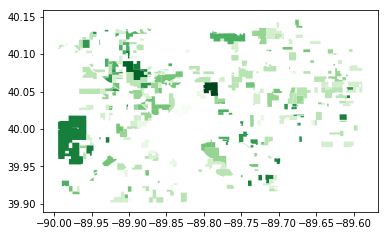

In [70]:
con = psycopg2.connect('host=localhost dbname=sdb_vinegap user=postgres password=secret')

sql = "SELECT * FROM farm_silo_count2;"

parcels = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')

# I'm going to plot by silo count to see if the final map looks similiar
parcels.plot(column='silo_count', cmap='Greens')

#### Because this is a GeoPandas dataframe, I can also view and manipulate the attribute table

In [71]:
parcels.head(3)

,owner,taxbill_ad,taxbill_cs,geom,silo_count,silo_avg_di
0,PAYDON WILLIAM DEAN & CLARA M,26466 W 135TH ST,PLAINFIELD IL 60544,(POLYGON ((-89.79057023432674 40.0441750931560...,11,7.4
1,SCHIRDING JOHN H ETAL,17762 SCHIRDING AVE,PETERSBURG IL 62675,(POLYGON ((-89.88478745693065 40.0676313223312...,10,7.3
2,POWELL CHESTER L,16986 PEORIA ST,ATHENS IL 626130000,(POLYGON ((-89.61854156057514 40.0122271605793...,9,11.6


#### The original silo measurements and my averaged silo measurments per parcel do not exactly match the known measurements from the silo pdf. I'll need to create a function that matches my "silo_avg_di" to the "Diameter" Key in my dictionary.

In [72]:
# If I had height information to match to I could do the same process here 
# and combine this info to determine a more precise capacity

#height_range = list(df2.Eave_Height_m.unique())
#print(height_range)

#First I'll get a range diameter values
diameter_range = list(df2.Diameter.unique())
print(diameter_range)

[4.6, 5.5, 6.4, 7.3, 8.2, 9.1, 10.1, 11.0, 12.8, 14.6]


In [73]:
def closest_diameter(number):
    return min(diameter_range, key=lambda x:abs(x-number))

parcels['closest_di'] = parcels['silo_avg_di'].apply(closest_diameter)
parcels.head(3)

,owner,taxbill_ad,taxbill_cs,geom,silo_count,silo_avg_di,closest_di
0,PAYDON WILLIAM DEAN & CLARA M,26466 W 135TH ST,PLAINFIELD IL 60544,(POLYGON ((-89.79057023432674 40.0441750931560...,11,7.4,7.3
1,SCHIRDING JOHN H ETAL,17762 SCHIRDING AVE,PETERSBURG IL 62675,(POLYGON ((-89.88478745693065 40.0676313223312...,10,7.3,7.3
2,POWELL CHESTER L,16986 PEORIA ST,ATHENS IL 626130000,(POLYGON ((-89.61854156057514 40.0122271605793...,9,11.6,11.0


#### Now I'm going to make a 'median bushel' and an 'estimated total bushels' column. I'll use the .map function to map the dictionary into the dataframe.

In [74]:
# Map the dictionary values into the dataframe
parcels['low_bushels'] = parcels['closest_di'].map(bushel_dict_min)
parcels['high_bushels'] = parcels['closest_di'].map(bushel_dict_max)
parcels['median_bushels'] = parcels['closest_di'].map(bushel_dict)

# Create new column and do the calculation
parcels['est_tot_low_bushels'] = parcels['silo_count'] * parcels['low_bushels']
parcels['est_tot_high_bushels'] = parcels['silo_count'] * parcels['high_bushels']
parcels['est_tot_median_bushels'] = parcels['silo_count'] * parcels['median_bushels']

# Drop columns used in calculatin for clarity
parcels.drop(['low_bushels', 'high_bushels', 'median_bushels'], axis=1)

# Sort based on the estimated total median bushels
parcels.sort_values('est_tot_median_bushels', ascending=False).head(5)

,owner,taxbill_ad,taxbill_cs,geom,silo_count,silo_avg_di,closest_di,low_bushels,high_bushels,median_bushels,est_tot_low_bushels,est_tot_high_bushels,est_tot_median_bushels
4,GRIGSBY FAMILY PARTNERSHIP,10736 MARKERT AV,TALLULA IL 62688,(POLYGON ((-89.98987808275918 39.9599203194489...,9,12.0,12.8,21512,47174,34343.0,193608,424566,309087.0
2,POWELL CHESTER L,16986 PEORIA ST,ATHENS IL 626130000,(POLYGON ((-89.61854156057514 40.0122271605793...,9,11.6,11.0,15349,34199,24774.0,138141,307791,222966.0
3,WINKELMANN WAYNE A,14944 WHITES CROSSING AV,PETERSBURG IL 62675,(POLYGON ((-89.90853235843124 40.0744678977034...,9,9.8,10.1,12706,28543,20625.0,114354,256887,185625.0
5,CARTER LESTER B & IRMA CORRINE,24945 ETHELL AV,ATHENS IL 626130000,(POLYGON ((-89.73623016650971 39.9238850248117...,9,10.1,10.1,12706,28543,20625.0,114354,256887,185625.0
78,TODD JAMES H TRUSTEE,29953 SWEETWATER AVE,GREENVIEW IL 62642,(POLYGON ((-89.61428490277886 40.0340663643501...,4,12.1,12.8,21512,47174,34343.0,86048,188696,137372.0


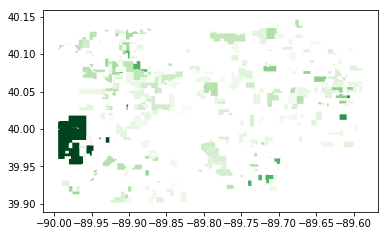

In [75]:
parcels.plot(column='est_tot_median_bushels', cmap='Greens')

### The Grigsby family of Tallula, Illinois tops the list!

## Time to save the results and visualize them on the web

In [78]:
# GeoJSON for the web
parcels.to_file("menard_il_potential_indigo_leads.geojson", driver='GeoJSON')

#Trusty shapefile
parcels.to_file("menardmenard_il_potential_indigo_leads.shp", driver='ESRI Shapefile')

### A quick look at the Grigsby parcel satellite view shows even more silo capacity than was captured!

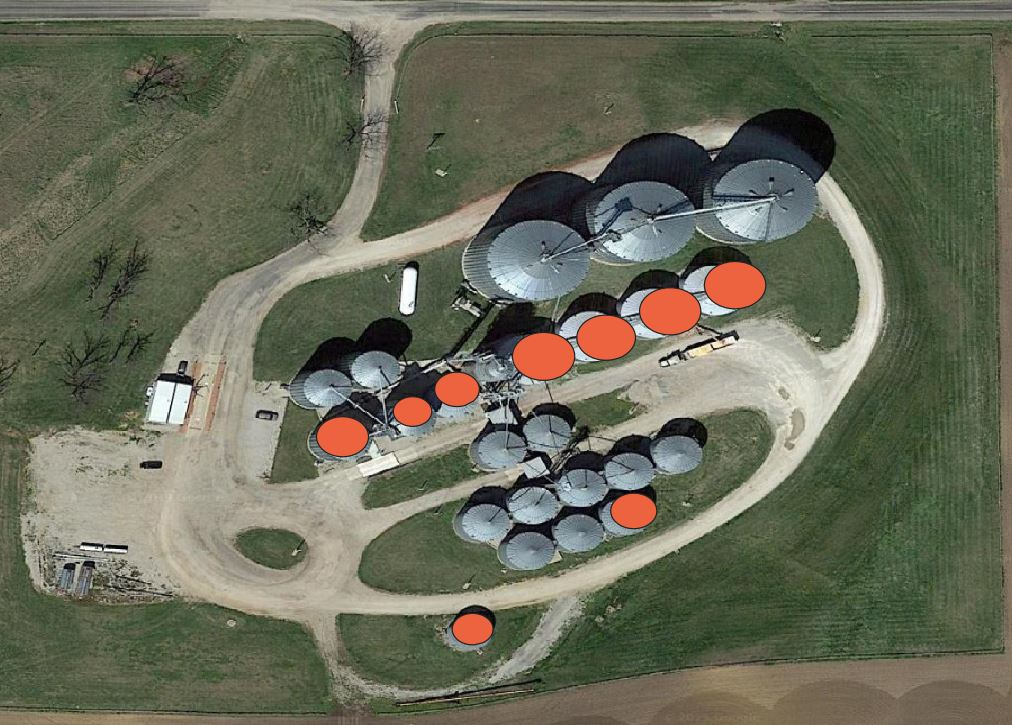